# Large_Melt_Map

Calculate SIR and GRD melt onset dates for selected subset areas.

Also calculates average across years.

Saves SIR and GRD MOD data in pickle files

Makes maps of various annual and/or average results.

FIXME: 
The pixel overlays are simply a scatter plot with rectangular markers and are not using EASE-grid projection

FIXME:
Add a location for where to find the RGI overlays
and read/display the RGI shapefiles

## Load in all the modules needed

In [1]:
%pylab notebook
# check if a windows machine, it needs special attention
# this extra step will bypass an error from mpl_toolkits.basemap
import os
if os.name == 'nt':
    os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share")
    os.environ["GDAL_DATA"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share", "gdal")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from pathlib import Path
import re
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap
import glob
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.min_rows', 200)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 10)

In [3]:
# Define the local machine location of CETB data cubes
# This directory is expected to contain subdirectories in the following hierarchy
# that duplicates the hierarchy on the Google Shared Drive NSIDC-SD-CETB/v1/, 
# for example:
# dataDir/F13_SSMI/N/nc_cubes/cubes_<regionName>
user = 'Mariah' #Mariah #MJWindows
if ('Joan' == user):
    dataDir = '/mnt/data3/cetb/nsidc0630_v1/' #jmr machine fringe 
    scriptDir = '/mnt/data3/cetb/ipynb_melt_onset/scripts'
elif ('Mariah' == user):
    dataDir = Path(Path.home(), 'nsidc0630_v1') # Mariah's PC or Mary Jo's Mac
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
elif ('MJWindows' == user):
    dataDir = Path('Z:/mj On My Mac/nsidc0630_v1') # Mary Jo's Windows machine
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
else:
    raise ValueError("unknown user= %s\n" % (user) )
    
%cd $scriptDir
dataDir, user

C:\Users\mtm220\ipynb_melt_onset\scripts


(WindowsPath('C:/Users/mtm220/nsidc0630_v1'), 'Mariah')

In [4]:
# load the custom functions
from CETB_read_functions import read_Tb_whole
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_cube_offset
from CETB_read_functions import grid_locations_of_subset
from CETB_read_functions import years_for
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array

## Specify inputs

In [5]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='WesternCA'  #'GLaIL'  #make this the same syntax as cubefilenames and sub-directory
sat_GRD='F13'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'F13'
sensor_GRD='SSMI'  #'AMSRE', 'SSMI', etc.
sensor_SIR='SSMI'
channel_GRD='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='37V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'

# set the sir to grd factor, depends on the channel
if (re.match('^[389]', channel_GRD)):
    sir_2_grd_factor = 8 # assume 3.125 km to 25 km
elif (re.match('^[12]', channel_GRD)):
    sir_2_grd_factor = 4 # assume 6.25 km to 25 km
else:
    raise ValueError("Cannot determine sir_2_grd_factor from channel %s\n" % (channel_GRD) )

cubeType_GRD = channel_GRD + '-' + alg_GRD
cubeType_SIR = channel_SIR + '-' + alg_SIR
  
if ('SSMI' == sensor_GRD) or ('SSMIS' == sensor_GRD):
    provider='CSU' 
    version='v1.*'
elif 'AMSRE' == sensor_GRD:
    provider='RSS'
    version='v1.3'

hemName = 'N'    

# on Joan's machine
#datadir_GRD = dataDir + sat_GRD+'_'+sensor_GRD+'/'+region+'/' 
#datadir_SIR = dataDir + sat_SIR+'_'+sensor_SIR+'/'+region+'/' 
# on MJ's machine
datadir_GRD = "%s/%s_%s/%s/nc_cubes/cubes_%s/" % (
    dataDir, sat_GRD, sensor_GRD, hemName, region )
datadir_SIR = "%s/%s_%s/%s/nc_cubes/cubes_%s/" % (
    dataDir, sat_SIR, sensor_SIR, hemName, region )

# prefix filepath
prefix_GRD = 'CETB.cubefile.'+region+'.'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'-'+provider+'-'+version
prefix_SIR = 'CETB.cubefile.'+region+'.'+sat_SIR+'_'+sensor_SIR+'-'+channel_SIR+'-'+alg_SIR+'-'+provider+'-'+version

Years=years_for(sat_GRD)
#might want to truncate Years to subset if very slow during testing
#if we give it more years than available what do we want it to do? 
#warn me but return what it finds

#Enter a site name for titles of plots
Site='Great Slave Lake, Canada'  #'Vatnajokull, Iceland'

In [6]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels within the corners of these coordinates
areaname='bathurst_range' #'gsl' #'hunza' #'vatna'

if ('vatna' == areaname):
    lat_start=63.75  
    lat_end=64.88    
    lon_start=-20 
    lon_end=-15  
    #Enter a site name for titles of plots
    Site='Vatnajokull, Iceland'
elif 'hunza' == areaname:
    lat_start=35.9  
    lat_end=37.1   
    lon_start=74 
    lon_end=76 
    #Enter a site name for titles of plots
    Site='Hunza Basin'
elif 'gsl' == areaname:
    lat_start=59.00  
    lat_end=67.00   
    lon_start=-119.00 
    lon_end=-107.00
    #Enter a site name for titles of plots
    Site='Great Slave Lake, Canada'
elif 'bathurst_range' == areaname:
    lat_start=58.00  
    lat_end=69.00   
    lon_start=-125.00 
    lon_end=-106.00
    #Enter a site name for titles of plots
    Site='Bathurst Caribou Range, NWT'
else: 
    raise ValueError("Unknown area name=%s" % (areaname) )

In [7]:
# get cube offset for finding row/col
# function is region specific
find_cube_offset(region, cubeDir=datadir_SIR, cubeType=cubeType_SIR, verbose=False)

Reading offset information from cubeFile=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-SIR-CSU-v1.3.2009.TB.nc...


(1895.9999999131005, 1743.9999998996689)

In [8]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
# and then calculate the corrsponding SIR pixel row/col numbers
rows_cols_GRD=coords(datadir_GRD, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_env = tuple(np.array(rows_cols_GRD) * sir_2_grd_factor)
print(rows_cols_GRD)
print(rows_cols_env)

(42, 94, 7, 40)
(336, 752, 56, 320)


In [12]:
# load in SIR TB data
# Truncate Years here for speed 
subYears = Years[0:3]

data_SIR = read_Tb_whole(datadir_SIR, prefix_SIR, subYears,
                         rows_cols_env[0], rows_cols_env[1], rows_cols_env[2], rows_cols_env[3])
CETB_SIR = data_SIR['TB']   # 3-D Tb time-series array of TB
cal_date = data_SIR['cal_date']    # 1-D array of dates, these will get passed to later functions
cal_year = data_SIR['cal_year']    # 1-D array of years
cal_month = data_SIR['cal_month']   # 1-D array of months

# load GRD Tb data
data_GRD = read_Tb_whole(datadir_GRD, prefix_GRD, subYears,
                         rows_cols_GRD[0], rows_cols_GRD[1], rows_cols_GRD[2], rows_cols_GRD[3])
CETB_GRD=data_GRD['TB']

Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-SIR-CSU-v1.3.1995.TB.nc...
Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-SIR-CSU-v1.3.1996.TB.nc...
Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-SIR-CSU-v1.3.1997.TB.nc...
Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-GRD-CSU-v1.3.1995.TB.nc...
Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-GRD-CSU-v1.3.1996.TB.nc...
Next filename=C:\Users\mtm220\nsidc0630_v1/F13_SSMI/N/nc_cubes/cubes_WesternCA\CETB.cubefile.WesternCA.F13_SSMI-37V-GRD-CSU-v1.3.1997.TB.nc...


In [13]:
# calculate DAV for the Tb data that was imported
DAV_SIR = calc_DAV(CETB_SIR)
DAV_GRD = calc_DAV(CETB_GRD)

## get the latitudes and longitudes of each pixel for plotting

In [14]:
# Get lat/lon of each pixel in the subset of 64 in the data_SIR dict
lat_lon = np.dstack((data_SIR['latitude'], data_SIR['longitude']))
coordinates = lat_lon[rows_cols_env[0]:rows_cols_env[1],
                      rows_cols_env[2]:rows_cols_env[3]]
coordinates = coordinates.reshape(
    ((rows_cols_env[1] - rows_cols_env[0]) * (rows_cols_env[3] - rows_cols_env[2])),
    2)

pixel_lats = coordinates[:,0]
pixel_lons = coordinates[:,1]
pixel_lats, pixel_lons

(masked_array(data=[54.15733081, 54.18262981, 54.20792067, ...,
                    66.00543607, 66.03299432, 66.06054854],
              mask=False,
        fill_value=1e+20),
 masked_array(data=[-120.95595057, -120.9793791 , -121.0028396 , ...,
                    -105.8575261 , -105.87594651, -105.89440865],
              mask=False,
        fill_value=1e+20))

In [15]:
# Get lat/lon of each pixel in the subset of the data_GRD dict
lat_lon = np.dstack((data_GRD['latitude'], data_GRD['longitude']))
coordinates = lat_lon[rows_cols_GRD[0]:rows_cols_GRD[1],
                      rows_cols_GRD[2]:rows_cols_GRD[3]]
coordinates = coordinates.reshape(
    ((rows_cols_GRD[1] - rows_cols_GRD[0]) * (rows_cols_GRD[3] - rows_cols_GRD[2])),
    2)

pixel_lats_GRD = coordinates[:,0]
pixel_lons_GRD = coordinates[:,1]
pixel_lats_GRD, pixel_lons_GRD

(masked_array(data=[54.29896461, 54.50115952, 54.70283056, ...,
                    65.49543841, 65.71612004, 65.93654386],
              mask=False,
        fill_value=1e+20),
 masked_array(data=[-120.90106971, -121.08981965, -121.28065474, ...,
                    -105.76419543, -105.90883191, -106.0560766 ],
              mask=False,
        fill_value=1e+20))

In [16]:
# size of lat/lon arrays
num_lats_SIR=shape(pixel_lats)[0]
num_lons_SIR=shape(pixel_lons)[0]
num_lats_GRD=shape(pixel_lats_GRD)[0]
num_lons_GRD=shape(pixel_lons_GRD)[0]

## create arrays of MOD to be used for plotting

In [17]:
# get array of average MODs for SIR pixels for all the years loaded
#Colorado (Johnson et al 2020) used 5 times in 7 day window
#Patagonia (Monahan and Ramage 2010) and Yukon (Semmens et al 2013?) used 3 times in 5 day window
window = 10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count = 3    # number of Tb/DAV exceedances to trigger MOD
#From Johnson et al 2020 AMSRE rSIR Tb >= 249 DAV>=13 and AMSRE GRD Tb>=243 DAV>=14
#From Johnson et al 2020 SSMI rSIR and GRD Tb>=247 DAV>=10
DAV_threshold = 10
Tb_threshold = 247

# sir MOD array - MOD will be in day of year (DOY) #changeback to Years for all years
MOD_DOY_array, MOD_DOY_df, meltflag_df = MOD_array(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, 
                                      rows_cols_env, cal_date, subYears, window, count, 
                                      DAV_threshold, Tb_threshold)
MOD_DOY_df

newdata.shape (2192, 109824)
moving flag array to newdata...
number of days = 2192
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
dataFrame is ready with flag data
doing rolling sums...
Next year = 1995...
Next year = 1996...
Next year = 1997...


,1995,1996,1997,Avg
"(row,col)",,,,
"336,56",128.0,103.0,97.0,109.33...
"336,57",128.0,104.0,97.0,109.66...
"336,58",128.0,104.0,97.0,109.66...
"336,59",128.0,103.0,97.0,109.33...
"336,60",128.0,103.0,97.0,109.33...
"336,61",128.0,103.0,97.0,109.33...
"336,62",128.0,73.0,97.0,99.333333
"336,63",128.0,73.0,95.0,98.666667
"336,64",128.0,73.0,97.0,99.333333


In [18]:
#Make a matching data frame with lat long for each pixel
array=np.zeros((2,num_lats_SIR))
geolocation_SIR_df = pd.DataFrame(array, columns = meltflag_df.columns, index=['Latitude','Longitude'])
geolocation_SIR_df.loc['Latitude']=pixel_lats.data
geolocation_SIR_df.loc['Longitude']=pixel_lons.data
geolocation_SIR_df

,"336,56","336,57","336,58","336,59","336,60",...,"751,315","751,316","751,317","751,318","751,319"
Latitude,54.157331,54.182630,54.207921,54.233203,54.258478,...,65.950308,65.977874,66.005436,66.032994,66.060549
Longitude,-120.95...,-120.97...,-121.00...,-121.02...,-121.04...,...,-105.82...,-105.83...,-105.85...,-105.87...,-105.89...


In [19]:
# MOD of the GRD pixel - avg all years
MOD_DOY_array_GRD, MOD_DOY_GRD_df, meltflag_GRD_df = MOD_array(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, 
                                              rows_cols_GRD, cal_date, subYears, window, count, 
                                              DAV_threshold, Tb_threshold)
MOD_DOY_GRD_df

newdata.shape (2192, 1716)
moving flag array to newdata...
number of days = 2192
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
dataFrame is ready with flag data
doing rolling sums...
Next year = 1995...
Next year = 1996...
Next year = 1997...


,1995,1996,1997,Avg
"(row,col)",,,,
"42,7",128.0,108.0,97.0,111.00...
"42,8",129.0,73.0,97.0,99.666667
"42,9",128.0,106.0,105.0,113.00...
"42,10",127.0,73.0,97.0,99.000000
"42,11",127.0,49.0,95.0,90.333333
"42,12",128.0,77.0,55.0,86.666667
"42,13",127.0,52.0,54.0,77.666667
"42,14",NaN,51.0,54.0,52.500000
"42,15",128.0,73.0,58.0,86.333333


In [20]:
array=np.zeros((2,num_lats_GRD))
geolocation_GRD_df = pd.DataFrame(array, columns = meltflag_GRD_df.columns, index=['Latitude','Longitude'])
geolocation_GRD_df.loc['Latitude'] = pixel_lats_GRD.data
geolocation_GRD_df.loc['Longitude'] = pixel_lons_GRD.data
geolocation_GRD_df

,"42,7","42,8","42,9","42,10","42,11",...,"93,35","93,36","93,37","93,38","93,39"
Latitude,54.298965,54.50116,54.702831,54.903973,55.104580,...,65.053314,65.274502,65.495438,65.716120,65.936544
Longitude,-120.90...,-121.08982,-121.28...,-121.47...,-121.66...,...,-105.48...,-105.62...,-105.76...,-105.90...,-106.05...


# Notes about changes from original notebooks:

The old notebooks used to call MOD_array to get the average MOD for a set of years 
and then call MOD_array_year for a given year of interest.

Now we just call MOD_array for SIR data and GRD data, and get back a data frame with 
MOD columns for each individual year, and one column for the avg MOD for all the years.

This will run much faster, and can be saved and just re-read from a saved file on disk.

N.B. Eventually we should just be able to read saved pickle files with the data we have already saved with:

new = pd.read_pickle(MOD_DOY_filename)

# Save the MOD by year data frames for SIR and GRD to pickle files

Also saving geolocation and melt onset flag data frames

In [21]:
dataDir

WindowsPath('C:/Users/mtm220/nsidc0630_v1')

In [22]:
modsDir = "%s/MODs" % dataDir
if not os.path.isdir(modsDir):
    os.makedirs(modsDir)

filename = "%s/%s.%s.%s.%s.%s.MOD.pkl" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR)
MOD_DOY_df.to_pickle(filename)
print("MOD_DOY dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.MOD.pkl" % (
    modsDir, region, areaname, sat_GRD, channel_GRD, alg_GRD)
MOD_DOY_GRD_df.to_pickle(filename)
print("MOD_DOY_GRD dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.meltflag.pkl" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR)
meltflag_df.to_pickle(filename)
print("meltflag_df dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.meltflag.pkl" % (
    modsDir, region, areaname, sat_GRD, channel_GRD, alg_GRD)
meltflag_GRD_df.to_pickle(filename)
print("meltflag_GRD_df dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.geolocation.pkl" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR)
geolocation_SIR_df.to_pickle(filename)
print("geolocation_SIR_df dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.geolocation.pkl" % (
    modsDir, region, areaname, sat_GRD, channel_GRD, alg_GRD)
geolocation_GRD_df.to_pickle(filename)
print("geolocation_GRD_df dataframe saved to %s\n" % filename)

MOD_DOY dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.SIR.MOD.pkl

MOD_DOY_GRD dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.GRD.MOD.pkl

meltflag_df dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.SIR.meltflag.pkl

meltflag_GRD_df dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.GRD.meltflag.pkl

geolocation_SIR_df dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.SIR.geolocation.pkl

geolocation_GRD_df dataframe saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.GRD.geolocation.pkl



## create the maps

In [ ]:
#how to create subplots with basemap (w maps) https://basemaptutorial.readthedocs.io/en/latest/subplots.html

<IPython.core.display.Javascript object>


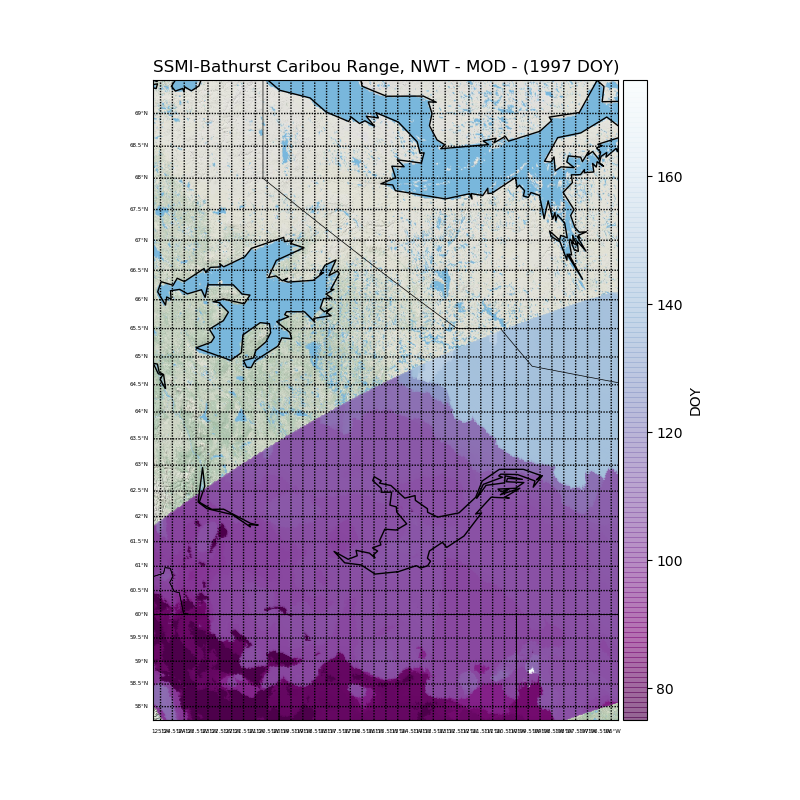

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-13948332.196397178,7904559.1871327795,-11766470.176849017,10907895.738923904&bboxSR=3857&imageSR=3857&size=1500,2064&dpi=96&format=png32&transparent=true&f=image
avg saved to C:\Users\mtm220\nsidc0630_v1/MODs/WesternCA.bathurst_range.F13.37V.SIR.1997DOY.png



In [23]:
# PLOT the MOD MAP - avg of all years or one year of interest - SIR
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
year=1997
#plot_type='all'


if plot_type == 'all':
    array = MOD_DOY_df['Avg']
    label = 'AvgDOY'+str(subYears[0])+'-'+str(subYears[-1])
    title = sensor_SIR + '-' + Site + ' - MOD - (Avg DOY '+str(subYears[0])+'-'+str(subYears[-1])+')'
elif plot_type == 'year':
    array = MOD_DOY_df[year]
    label = str(year)+'DOY' 
    title = sensor_SIR + '-' + Site + ' - MOD - (' + str(year) + ' DOY)'

# Set a few common things
graticule_fontsize = 4

# create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',
            lon_0=(lon_start+lon_end)/2,
            lat_0=(lat_start+lat_end)/2,
            lat_ts=90.,
            llcrnrlat=(lat_start-.3),
            urcrnrlat=(lat_end+.5),
            llcrnrlon=(lon_start-.3),
            urcrnrlon=(lon_end+.3),
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000, 
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=graticule_fontsize)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=graticule_fontsize)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
#m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Iceland', color='red', linewidth=1)

x,y = m(pixel_lons, pixel_lats)
#m.scatter(x,y,c=array, s=30, marker='s',lw=0,cmap='RdBu', alpha=.6) #this line is what was here
im = m.scatter(x, y, c=array, s=30, marker='s',
              lw=0, cmap='BuPu_r', alpha=.6) # this line is for testing PuOr, rainbow,binary good for Tb
plt.title(title)

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.05 in.
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()

filename = "%s/%s.%s.%s.%s.%s.%s.png" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR, label)
plt.savefig(filename)
print("avg saved to %s\n" % filename)

In [ ]:
#color bars here https://matplotlib.org/stable/tutorials/colors/colormaps.html
#documentation on basemap https://matplotlib.org/basemap/users/laea.html

In [ ]:
# Trial-and-error decide on size for GRD vs. SIR scatter markers
#np.sqrt((1200)/8)^2
sGRD=700
sSIR=12

In [ ]:
# 2plots left (GRD) and right (SIR)
#redo basemap to be in easegrid projection EASE2.0

# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
year=2018
#plot_type='all'


if plot_type == 'all':
    sir_array = MOD_DOY_df['Avg']
    sir_title = sensor_SIR + '-' + Site + ' rSIR MOD (Avg DOY '+str(subYears[0])+'-'+str(subYears[-1])+')'
    grd_array = MOD_DOY_GRD_df['Avg']
    grd_title = sensor_GRD + '-' + Site + ' GRD MOD (Avg DOY '+str(subYears[0])+'-'+str(subYears[-1])+')'
elif plot_type == 'year':
    sir_array = MOD_DOY_df[year]
    sir_title = sensor_SIR + '-' + Site + ' rSIR MOD (' + str(year) + ' DOY)'
    grd_array = MOD_DOY_GRD_df[year]
    grd_title = sensor_GRD + '-' + Site + ' GRD MOD (' + str(year) + ' DOY)'

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Set a few common things
graticule_fontsize = 8

#min day of year to plot
minday=75
#max day of year to plot
maxday=175

# create polar stereographic Basemap instance.
axes[0].set_title(grd_title)
m = Basemap(ax=axes[0],projection='stere',
            lon_0=(lon_start+lon_end)/2,
            lat_0=(lat_start+lat_end)/2,lat_ts=90.,
            llcrnrlat=(lat_start-.3),
            urcrnrlat=(lat_end+.5),
            llcrnrlon=(lon_start-.3),
            urcrnrlon=(lon_end+.3),
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000, 
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=graticule_fontsize)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=graticule_fontsize)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
#m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y = m(pixel_lons_GRD, pixel_lats_GRD)
im0 = m.scatter(x, y, c=grd_array, 
                s=sGRD, marker='s',lw=0,cmap='BuPu_r', alpha=.6, vmin=minday, vmax=maxday) #RdBu, 

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.08 in.
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.08)
cbar = plt.colorbar(im0, cax=cax, label='DOY')
cbar.set_clim(minday, maxday)  #color bar limits

axes[1].set_title(sir_title)
m = Basemap(ax=axes[1],projection='stere',
            lon_0=(lon_start+lon_end)/2,
            lat_0=(lat_start+lat_end)/2,lat_ts=90.,
            llcrnrlat=(lat_start-.3),
            urcrnrlat=(lat_end+.5),
            llcrnrlon=(lon_start-.3),
            urcrnrlon=(lon_end+.3),
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000, 
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
#m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y = m(pixel_lons, pixel_lats)
im1 = m.scatter(x, y, c=sir_array, 
                s=sSIR, marker='s', lw=0,cmap='BuPu_r', alpha=.6,vmin=minday,vmax=maxday) #RdBu, 
#fig.colorbar(im1, ax=axes[1],label='DOY')
#plt.clim(75,175)  #color bar limits

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.05 in.
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, label='DOY')
cbar.set_clim(minday, maxday)  #color bar limits

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# PLOT the MOD MAP - avg of all years or one year of interest - GRD
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
#plot_type='all'
year=2019

if plot_type=='all':
    array=MOD_DOY_array_GRD
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_GRD_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y=m(pixel_lons_GRD, pixel_lats_GRD)
m.scatter(x,y,c=array, s=1200, marker='s',lw=0,cmap='BuPu_r', alpha=.6) #RdBu, 

plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

plt.title(title)
plt.show()

In [ ]:
#setup a dataframe so that all the data from ssmi and ssmis are read into one array for long term average
#need to decide which sensor has priority when there is overlap
#can create a reader that loops through enough sensors to get a full time series 
#(skip F10- orbit very elliptical and F19 - short)
#create that time series for the analysis, save for analysis
#
#save dataframes with MOD so that we can do other analysys
#pickle the data frame that is inside the MOD_array_DOY function 
#
#check in CETB_analysis.py that when it does the count/window it is in fact 
#saving the first occurrence of the count, even though it doesn't know until it gets to 3x

In [ ]:
#Add to this
#Plot of which pixels have melted as of a specific day

In [ ]:
#figure out refreeze? then from MOD to Freeze, count # of dates with Tb>=threshold (with or without DAV? might depend on site)

In [ ]:
#Add to this
#Plot of how many days (or occurrences) experienced melt 


In [ ]:
#Add to this
#Plot of how many short (1-2 occurrences) melt days EMEs prior to the first MOD
#From Jan 1 - MOD, Number of days with Tb>= threshold and DAV>= threshold (same thresholds)